<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [2]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

# 1. Reading Data

In [3]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph = nx.read_edgelist(
        'data/after_eda/train_pos_after_eda.csv',
        delimiter=',',
        create_using=nx.DiGraph(),
        nodetype=int
    )
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1780722 nodes and 7550015 edges


 # 2. Similarity measures

## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [4]:
#for followees

def jaccard_for_followees(a, b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/ \
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0

    return sim

In [5]:
set(train_graph.successors(1248963))

{27625, 326495, 645120, 816579, 1137190, 1191612, 1303325, 1487275}

In [6]:
#one test case
print(jaccard_for_followees(1248963, 1137190))

0.0


In [7]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084, 1505602))

0.0


In [8]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [9]:
print(jaccard_for_followers(273084, 1505602))

0


In [10]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354, 1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [11]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a))) * len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [12]:
print(cosine_for_followees(273084, 1505602))

0.0


In [13]:
print(cosine_for_followees(273084, 1635354))

0


In [14]:
def cosine_for_followers(a, b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [15]:
print(cosine_for_followers(2, 470294))

0.02886751345948129


In [16]:
print(cosine_for_followers(669354, 1635354))

0


# 3. Ranking Measures

## 3.1 Page Ranking

In [17]:
%%time
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

CPU times: user 194 ms, sys: 92.3 ms, total: 286 ms
Wall time: 306 ms


In [18]:
pr

{273084: 2.046179597856667e-06,
 1505602: 3.468854273333391e-07,
 912810: 1.0400703029782388e-06,
 1678443: 1.794695046043372e-06,
 365429: 1.0339107679487076e-06,
 1523458: 3.0977447861991786e-06,
 527014: 1.664541165527249e-07,
 1605979: 6.437885909962372e-07,
 1228116: 8.356923926167511e-07,
 471233: 2.6667653590861202e-06,
 866691: 1.5093006000585687e-06,
 535232: 1.281114512599222e-06,
 660560: 1.409938476246563e-06,
 1272982: 1.2316109396872717e-06,
 1409846: 1.2659938927809965e-06,
 845593: 1.3755816367124465e-06,
 628879: 4.3694365207071513e-07,
 858706: 8.824558282179932e-07,
 1114859: 1.664541165527249e-07,
 813966: 9.491311198862934e-07,
 976987: 1.0703063570360739e-06,
 182524: 2.8578773516360294e-07,
 1408148: 2.098481596839533e-07,
 973346: 2.266725804104179e-06,
 1085939: 5.474623378065726e-07,
 569150: 8.068778697644372e-07,
 396322: 7.516325733277143e-06,
 149376: 1.842729841009468e-06,
 117851: 5.051342912769312e-07,
 598891: 5.051342912769312e-07,
 1046713: 1.7395159

In [19]:
print('min', pr[min(pr, key=pr.get)])
print('max', pr[max(pr, key=pr.get)])
print('mean', float(sum(pr.values())) / len(pr))

min 1.664541165527249e-07
max 2.7107525037665647e-05
mean 5.615699699399617e-07


In [20]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699399617e-07


# 4. Other Graph Features

## 4.1 Shortest path:

In [21]:
def compute_shortest_path_length(a, b):
    p = -1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [22]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [23]:
#testing
compute_shortest_path_length(669354, 1635354)

-1

## 4.2 Checking for same community

In [24]:
%%time
wcc =  list(nx.weakly_connected_components(train_graph))
wcc

CPU times: user 8.68 s, sys: 1.62 s, total: 10.3 s
Wall time: 10.5 s


[{1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  13,
  14,
  16,
  18,
  19,
  20,
  21,
  22,
  24,
  25,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  70,
  71,
  72,
  73,
  74,
  75,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  105,
  106,
  107,
  108,
  110,
  111,
  112,
  113,
  115,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  142,
  143,
  144,
  145,
  146,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  166,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  17

In [25]:
#getting weekly connected edges from graph 
def belongs_to_same_wcc(a, b):
    index = []
    if train_graph.has_edge(b, a):
        return 1

    if train_graph.has_edge(a, b):
            for i in wcc:
                if a in i:
                    index = i
                    break
            if b in index:
                train_graph.remove_edge(a, b)
                if compute_shortest_path_length(a, b) == -1:
                    train_graph.add_edge(a, b)
                    return 0
                else:
                    train_graph.add_edge(a, b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if b in index:
                return 1
            else:
                return 0

In [26]:
belongs_to_same_wcc(861, 1659750)

0

In [27]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [28]:
#adar index
def calc_adar_in(a, b):
    sum = 0
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n) != 0:
            for i in n:
                sum = sum + (1 / np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [29]:
calc_adar_in(1,189226)

0

In [30]:
calc_adar_in(669354,1635354)

0

## 4.4 Is persion was following back:

In [31]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [32]:
follows_back(1,189226)

1

In [33]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [34]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph, alpha=0.005, beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))

In [35]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313693724721695
max 0.0033946298175455587
mean 0.0007483800858240464


In [36]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800858240464


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [37]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    os.mkdir('data/fea_sample')
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

In [38]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min -1.1088123555333443e-20
max 0.0048686533960754265
mean 5.615699699308767e-07


# 5. Featurization

In [39]:
import random
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    print('True')
    #https://stackoverflow.com/a/22259008/4084039

True


In [40]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [41]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [42]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,628879,858706,1


In [43]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1160264,1270588,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [44]:
if not os.path.isfile('data/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [45]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [46]:
if not os.path.isfile('data/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/storage_sample_stage1.h5', 'test_df',mode='r')

## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [47]:
if not os.path.isfile('data/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
 
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/storage_sample_stage2.h5', 'test_df',mode='r')

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [48]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in tqdm(train_graph.nodes()):
    s1 = set(train_graph.predecessors(i))
    w_in = 1.0 / (np.sqrt(1+len(s1)))
    Weight_in[i] = w_in
    
    s2 = set(train_graph.successors(i))
    w_out = 1.0 / (np.sqrt(1+len(s2)))
    Weight_out[i] = w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:13<00:00, 134626.95it/s]


In [49]:
if not os.path.isfile('data/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [50]:
if not os.path.isfile('data/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/storage_sample_stage3.h5', 'train_df', mode='r')
    df_final_test = read_hdf('data/storage_sample_stage3.h5', 'test_df', mode='r')

In [51]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.005929,0.877964,2.046180e-06,3.468854e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.172899e-16,2.231875e-15
1,1542325,1079302,1,0,0.000000,0.000000,0.000000,22,87,26,...,0.405651,0.491501,1.769878e-06,7.758772e-06,0.000821,0.001079,5.223144e-14,5.178044e-13,3.596557e-14,2.008261e-13
2,1295758,734119,1,0,0.583333,0.130931,0.737865,21,5,20,...,1.034714,0.844684,8.156016e-07,3.069328e-07,0.000814,0.000752,8.956499e-18,2.396427e-17,2.478123e-18,5.943260e-19
3,280719,1478518,1,0,0.000000,0.117851,0.000000,8,3,19,...,1.223607,0.947214,5.550145e-07,7.030068e-07,0.000763,0.000743,7.650053e-15,1.538840e-17,7.800343e-16,5.822188e-17
4,954712,658041,1,0,0.000000,0.000000,0.000000,9,16,10,...,0.786583,0.845558,1.158236e-06,1.468569e-06,0.000767,0.000794,7.531716e-15,6.731574e-15,1.242094e-13,1.167393e-14


### Adding new feature Preferential Attachement 

 One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.

### Preferential Attachement for followers (ASSIGNMENT)

In [52]:
#for train dataset
nfs = np.array(df_final_train['num_followers_s'])
nfd = np.array(df_final_train['num_followers_d'])
preferential_followers=[]

for i in range(len(nfs)):
    preferential_followers.append(nfd[i] * nfs[i])

df_final_train['prefer_Attach_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,0.877964,2.046180e-06,3.468854e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.172899e-16,2.231875e-15,66
1,1542325,1079302,1,0,0.000000,0.000000,0.000000,22,87,26,...,0.491501,1.769878e-06,7.758772e-06,0.000821,0.001079,5.223144e-14,5.178044e-13,3.596557e-14,2.008261e-13,1914
2,1295758,734119,1,0,0.583333,0.130931,0.737865,21,5,20,...,0.844684,8.156016e-07,3.069328e-07,0.000814,0.000752,8.956499e-18,2.396427e-17,2.478123e-18,5.943260e-19,105
3,280719,1478518,1,0,0.000000,0.117851,0.000000,8,3,19,...,0.947214,5.550145e-07,7.030068e-07,0.000763,0.000743,7.650053e-15,1.538840e-17,7.800343e-16,5.822188e-17,24
4,954712,658041,1,0,0.000000,0.000000,0.000000,9,16,10,...,0.845558,1.158236e-06,1.468569e-06,0.000767,0.000794,7.531716e-15,6.731574e-15,1.242094e-13,1.167393e-14,144


In [53]:
#for test dataset
nfs = np.array(df_final_test['num_followers_s'])
nfd = np.array(df_final_test['num_followers_d'])
preferential_followers=[]

for i in range(len(nfs)):
    preferential_followers.append(nfd[i]*nfs[i])

df_final_test['prefer_Attach_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,1.014128,6.566863e-07,1.560535e-06,0.000754,0.000786,3.243237e-16,1.745621e-16,2.969838e-15,9.268929e-14,84
1,1674114,540229,1,0,0.166667,0.267261,0.316228,14,4,10,...,1.050236,9.850628e-07,3.030904e-07,0.000785,0.000747,1.887417e-17,1.052489e-17,2.878756e-17,6.204433e-19,56
2,156634,1845101,1,0,0.000000,0.000000,0.000000,4,12,3,...,1.277350,7.768637e-07,1.978810e-06,0.000747,0.000777,1.519298e-17,2.307007e-15,2.556576e-16,1.369001e-13,48
3,226359,1042305,1,0,0.000000,0.044412,0.000000,3,13,3,...,1.267261,3.432447e-07,1.267691e-06,0.000743,0.000781,3.745808e-18,1.315912e-20,7.137759e-19,1.738813e-17,39
4,627485,1532635,1,0,0.000000,0.000000,0.000000,9,0,184,...,0.736010,6.434572e-07,5.615700e-07,0.000768,0.000748,6.512684e-10,0.000000e+00,1.179847e-14,0.000000e+00,0


### Preferential Attachement for followees (ASSIGNMENT)

In [54]:
#for train dataset
nfs = np.array(df_final_train['num_followees_s'])
nfd = np.array(df_final_train['num_followees_d'])
preferential_followees=[]

for i in range(len(nfs)):
    preferential_followees.append(nfd[i] * nfs[i])

df_final_train['prefer_Attach_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,2.046180e-06,3.468854e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.172899e-16,2.231875e-15,66,120
1,1542325,1079302,1,0,0.000000,0.000000,0.000000,22,87,26,...,1.769878e-06,7.758772e-06,0.000821,0.001079,5.223144e-14,5.178044e-13,3.596557e-14,2.008261e-13,1914,2990
2,1295758,734119,1,0,0.583333,0.130931,0.737865,21,5,20,...,8.156016e-07,3.069328e-07,0.000814,0.000752,8.956499e-18,2.396427e-17,2.478123e-18,5.943260e-19,105,360
3,280719,1478518,1,0,0.000000,0.117851,0.000000,8,3,19,...,5.550145e-07,7.030068e-07,0.000763,0.000743,7.650053e-15,1.538840e-17,7.800343e-16,5.822188e-17,24,76
4,954712,658041,1,0,0.000000,0.000000,0.000000,9,16,10,...,1.158236e-06,1.468569e-06,0.000767,0.000794,7.531716e-15,6.731574e-15,1.242094e-13,1.167393e-14,144,110


In [55]:
#for test dataset
nfs = np.array(df_final_test['num_followees_s'])
nfd = np.array(df_final_test['num_followees_d'])
preferential_followees=[]

for i in range(len(nfs)):
    preferential_followees.append(nfd[i] * nfs[i])

df_final_test['prefer_Attach_followees'] = preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,6.566863e-07,1.560535e-06,0.000754,0.000786,3.243237e-16,1.745621e-16,2.969838e-15,9.268929e-14,84,54
1,1674114,540229,1,0,0.166667,0.267261,0.316228,14,4,10,...,9.850628e-07,3.030904e-07,0.000785,0.000747,1.887417e-17,1.052489e-17,2.878756e-17,6.204433e-19,56,40
2,156634,1845101,1,0,0.000000,0.000000,0.000000,4,12,3,...,7.768637e-07,1.978810e-06,0.000747,0.000777,1.519298e-17,2.307007e-15,2.556576e-16,1.369001e-13,48,45
3,226359,1042305,1,0,0.000000,0.044412,0.000000,3,13,3,...,3.432447e-07,1.267691e-06,0.000743,0.000781,3.745808e-18,1.315912e-20,7.137759e-19,1.738813e-17,39,3
4,627485,1532635,1,0,0.000000,0.000000,0.000000,9,0,184,...,6.434572e-07,5.615700e-07,0.000768,0.000748,6.512684e-10,0.000000e+00,1.179847e-14,0.000000e+00,0,0


## 5.5 Adding new set of features 

<ol>
<li>SVD features for both source and destination</li>
</ol>

In [56]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0, 0, 0, 0, 0, 0]

In [57]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = {val:idx for idx, val in enumerate(sadj_col)}

In [58]:
Adj = nx.adjacency_matrix(train_graph, nodelist=sorted(train_graph.nodes())).asfptype()

In [59]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape', Adj.shape)
print('U Shape', U.shape)
print('V Shape', V.shape)
print('s Shape', s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [60]:
if not os.path.isfile('data/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    hdf = HDFStore('data/storage_sample_stage4.h5')
    hdf.put('train_df', df_final_train, format='table', data_columns=True)
    hdf.put('test_df', df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/storage_sample_stage4.h5', 'train_df', mode='r')
    df_final_test = read_hdf('data/storage_sample_stage4.h5', 'test_df', mode='r')
    print('Done')

In [61]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.983700e-06,1.545086e-13,8.108213e-13,1.719704e-14,-1.355368e-12,4.675313e-13,1.128585e-06,6.616691e-14,9.770697e-13,4.160010e-14
1,1542325,1079302,1,0,0.000000,0.000000,0.000000,22,87,26,...,1.334066e-09,1.594253e-09,4.676482e-10,6.703649e-13,-3.918681e-09,6.549511e-10,2.880453e-08,8.705201e-11,1.856911e-09,3.743214e-12
2,1295758,734119,1,0,0.583333,0.130931,0.737865,21,5,20,...,4.798256e-15,8.136328e-15,7.438452e-15,4.631685e-17,-3.500031e-16,5.030151e-15,1.109780e-15,1.867879e-15,1.737197e-15,1.111534e-17
3,280719,1478518,1,0,0.000000,0.117851,0.000000,8,3,19,...,6.493984e-11,1.492219e-13,2.744489e-10,1.453914e-14,-1.115235e-15,3.601496e-12,1.750915e-11,1.270759e-14,1.308095e-13,1.085202e-15
4,954712,658041,1,0,0.000000,0.000000,0.000000,9,16,10,...,6.326878e-09,5.649188e-12,3.679006e-11,2.315148e-12,-2.008418e-09,1.411095e-11,1.754017e-07,2.024084e-11,3.133877e-10,2.175913e-13


In [62]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'prefer_Attach_followers', 'prefer_Attach_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

### Adding feature svd_dot  (ASSIGNMENT)

 svd_dot is Dot product between sourse node svd and destination node svd features

In [63]:
#for train datasets
s1, s2, s3, s4, s5, s6 = df_final_train['svd_u_s_1'],\
                         df_final_train['svd_u_s_2'],\
                         df_final_train['svd_u_s_3'],\
                         df_final_train['svd_u_s_4'],\
                         df_final_train['svd_u_s_5'],\
                         df_final_train['svd_u_s_6']

s7, s8, s9, s10, s11, s12 = df_final_train['svd_v_s_1'],\
                            df_final_train['svd_v_s_2'],\
                            df_final_train['svd_v_s_3'],\
                            df_final_train['svd_v_s_4'],\
                            df_final_train['svd_v_s_5'],\
                            df_final_train['svd_v_s_6']

d1, d2, d3, d4, d5, d6 = df_final_train['svd_u_d_1'],\
                         df_final_train['svd_u_d_2'],\
                         df_final_train['svd_u_d_3'],\
                         df_final_train['svd_u_d_4'],\
                         df_final_train['svd_u_d_5'],\
                         df_final_train['svd_u_d_6']

d7, d8, d9, d10, d11, d12 = df_final_train['svd_v_d_1'],\
                            df_final_train['svd_v_d_2'],\
                            df_final_train['svd_v_d_3'],\
                            df_final_train['svd_v_d_4'],\
                            df_final_train['svd_v_d_5'],\
                            df_final_train['svd_v_d_6']
 

In [64]:
svd_dot=[]

for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))

df_final_train['svd_dot'] = svd_dot


In [65]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.545086e-13,8.108213e-13,1.719704e-14,-1.355368e-12,4.675313e-13,1.128585e-06,6.616691e-14,9.770697e-13,4.160010e-14,1.338827e-11
1,1542325,1079302,1,0,0.000000,0.000000,0.000000,22,87,26,...,1.594253e-09,4.676482e-10,6.703649e-13,-3.918681e-09,6.549511e-10,2.880453e-08,8.705201e-11,1.856911e-09,3.743214e-12,7.003556e-17
2,1295758,734119,1,0,0.583333,0.130931,0.737865,21,5,20,...,8.136328e-15,7.438452e-15,4.631685e-17,-3.500031e-16,5.030151e-15,1.109780e-15,1.867879e-15,1.737197e-15,1.111534e-17,1.570262e-26
3,280719,1478518,1,0,0.000000,0.117851,0.000000,8,3,19,...,1.492219e-13,2.744489e-10,1.453914e-14,-1.115235e-15,3.601496e-12,1.750915e-11,1.270759e-14,1.308095e-13,1.085202e-15,2.908841e-21
4,954712,658041,1,0,0.000000,0.000000,0.000000,9,16,10,...,5.649188e-12,3.679006e-11,2.315148e-12,-2.008418e-09,1.411095e-11,1.754017e-07,2.024084e-11,3.133877e-10,2.175913e-13,3.033894e-14


In [66]:
#for test dataset
s1, s2, s3, s4, s5, s6 = df_final_test['svd_u_s_1'],\
                         df_final_test['svd_u_s_2'],\
                         df_final_test['svd_u_s_3'],\
                         df_final_test['svd_u_s_4'],\
                         df_final_test['svd_u_s_5'],\
                         df_final_test['svd_u_s_6']

s7, s8, s9, s10, s11, s12 = df_final_test['svd_v_s_1'],\
                            df_final_test['svd_v_s_2'],\
                            df_final_test['svd_v_s_3'],\
                            df_final_test['svd_v_s_4'],\
                            df_final_test['svd_v_s_5'],\
                            df_final_test['svd_v_s_6']

d1, d2, d3, d4, d5, d6 = df_final_test['svd_u_d_1'],\
                         df_final_test['svd_u_d_2'],\
                         df_final_test['svd_u_d_3'],\
                         df_final_test['svd_u_d_4'],\
                         df_final_test['svd_u_d_5'],\
                         df_final_test['svd_u_d_6']

d7, d8, d9, d10, d11, d12 = df_final_test['svd_v_d_1'],\
                            df_final_test['svd_v_d_2'],\
                            df_final_test['svd_v_d_3'],\
                            df_final_test['svd_v_d_4'],\
                            df_final_test['svd_v_d_5'],\
                            df_final_test['svd_v_d_6']
 

In [67]:
svd_dot=[]

for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))

df_final_test['svd_dot']=svd_dot    


In [68]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,2.701518e-12,4.341620e-13,5.535503e-14,-9.993054e-10,5.791357e-10,3.512351e-07,2.486435e-09,2.771145e-09,1.727643e-12,2.083224e-17
1,1674114,540229,1,0,0.166667,0.267261,0.316228,14,4,10,...,2.443347e-14,1.239628e-13,5.365897e-16,-1.534315e-15,2.477054e-13,8.968297e-13,5.296211e-15,3.800199e-14,1.156661e-17,5.909274e-23
2,156634,1845101,1,0,0.000000,0.000000,0.000000,4,12,3,...,2.139214e-13,2.188712e-12,4.765223e-15,-1.613580e-12,1.047635e-12,2.231533e-11,2.885602e-12,1.665989e-11,2.551692e-12,2.239767e-21
3,226359,1042305,1,0,0.000000,0.044412,0.000000,3,13,3,...,6.144197e-14,1.904228e-14,1.331012e-17,-3.146439e-13,5.433097e-12,4.977691e-11,8.560803e-15,3.101547e-13,3.240935e-16,1.472143e-22
4,627485,1532635,1,0,0.000000,0.000000,0.000000,9,0,184,...,8.234007e-13,2.599192e-12,2.199127e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [69]:

hdf = HDFStore('data/storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [70]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [71]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'prefer_Attach_followers', 'prefer_Attach_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_dot'],
      dtype='object')

In [72]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [73]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.910577498812793 test Score 0.9032366540563261
Estimators =  50 Train Score 0.9192463966912949 test Score 0.9129094900371496
Estimators =  100 Train Score 0.9208481961791652 test Score 0.914358108108108
Estimators =  250 Train Score 0.9210194665194612 test Score 0.9151087048473057
Estimators =  450 Train Score 0.9210509879036456 test Score 0.915121662473839


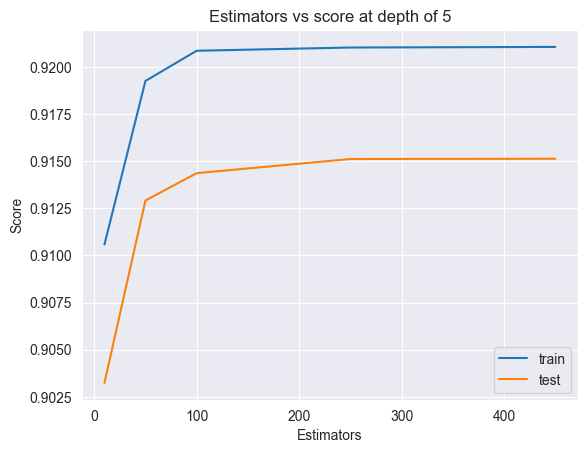

In [76]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []

for i in estimators:
    clf = RandomForestClassifier(
        bootstrap=True, class_weight=None, criterion='gini',
        max_depth=5, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=52, min_samples_split=120,
        min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,
        random_state=25,verbose=0,warm_start=False
    )
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)

plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.legend(['train', 'test'])
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')
plt.show()

depth =  3 Train Score 0.8815390090222102 test Score 0.8697085134614562
depth =  9 Train Score 0.9472550246745118 test Score 0.9222549663959972
depth =  11 Train Score 0.9569374089060573 test Score 0.9242122227405742
depth =  15 Train Score 0.9591055354160727 test Score 0.9249342272765849
depth =  20 Train Score 0.9591265682394001 test Score 0.9249332032740999
depth =  35 Train Score 0.9589668437442753 test Score 0.9246951542784434
depth =  50 Train Score 0.9589668437442753 test Score 0.9246951542784434
depth =  70 Train Score 0.9589668437442753 test Score 0.9246951542784434
depth =  130 Train Score 0.9589668437442753 test Score 0.9246951542784434


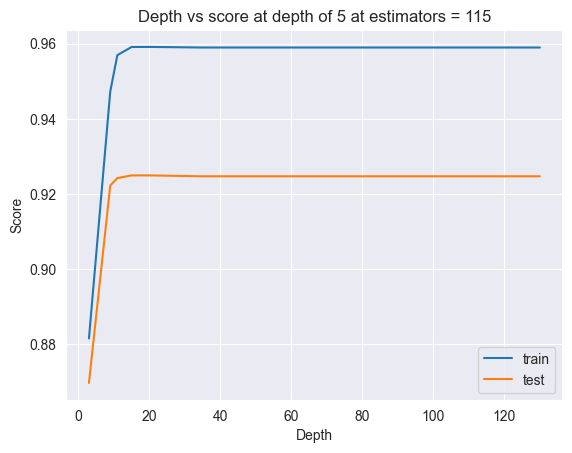

In [79]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []

for i in depths:
    clf = RandomForestClassifier(
        bootstrap=True, class_weight=None, criterion='gini',
        max_depth=i, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=52, min_samples_split=120,
        min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
        random_state=25, verbose=0, warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)

plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.legend(['train', 'test'])
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [88]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105, 125),
              "max_depth": sp_randint(10, 20),
              "min_samples_split": sp_randint(100, 200),
              "min_samples_leaf": sp_randint(25, 65)}

clf = RandomForestClassifier(random_state=25, n_jobs=-1)

rf_random = RandomizedSearchCV(
    clf, param_distributions=param_dist,
    n_iter=10, cv=10, scoring='f1',
    random_state=25,
    return_train_score=True,
    n_jobs=-1
)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.95785639 0.95711351 0.95690246 0.95907275 0.95901771 0.95846652
 0.95739713 0.95560816 0.95621589 0.95639242]
mean train scores [0.95882491 0.95812691 0.95803128 0.96015897 0.96027799 0.95953468
 0.95826803 0.95626349 0.95733087 0.95753828]


In [90]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=17, min_samples_leaf=28, min_samples_split=188,
                       n_estimators=108, n_jobs=-1, random_state=25)


In [104]:
clf=RandomForestClassifier(
    criterion='gini',
    max_depth=15,
    max_leaf_nodes=None,
    min_samples_leaf=20,
    min_samples_split=150,
    n_estimators=100,
    n_jobs=-1,
    random_state=25
)


In [105]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [106]:
from sklearn.metrics import f1_score

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9610997010797732
Test f1 score 0.9264197740232761


In [94]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = ((C.T) / (C.sum(axis=1))).T
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


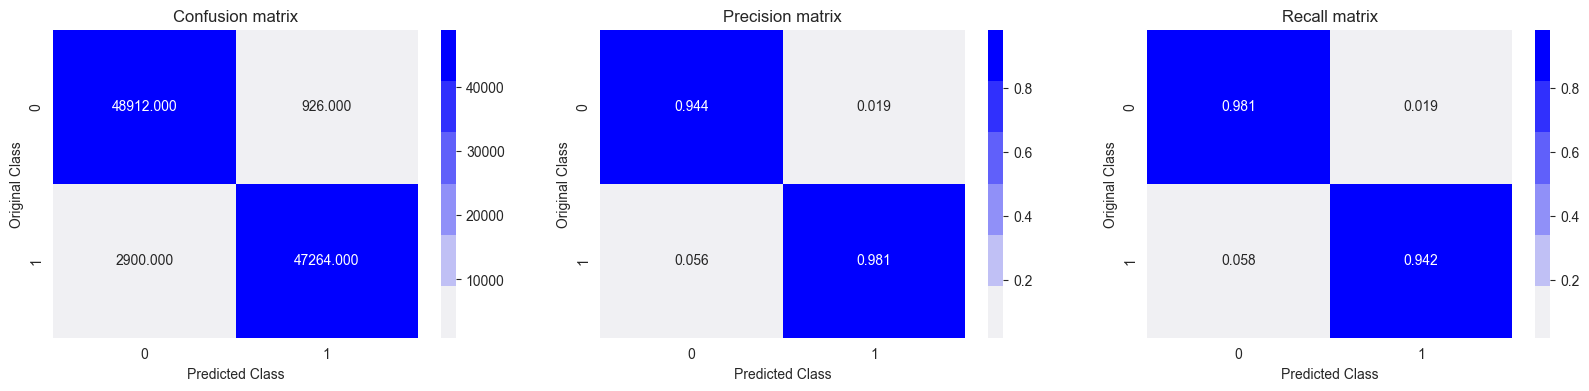

Test confusion_matrix


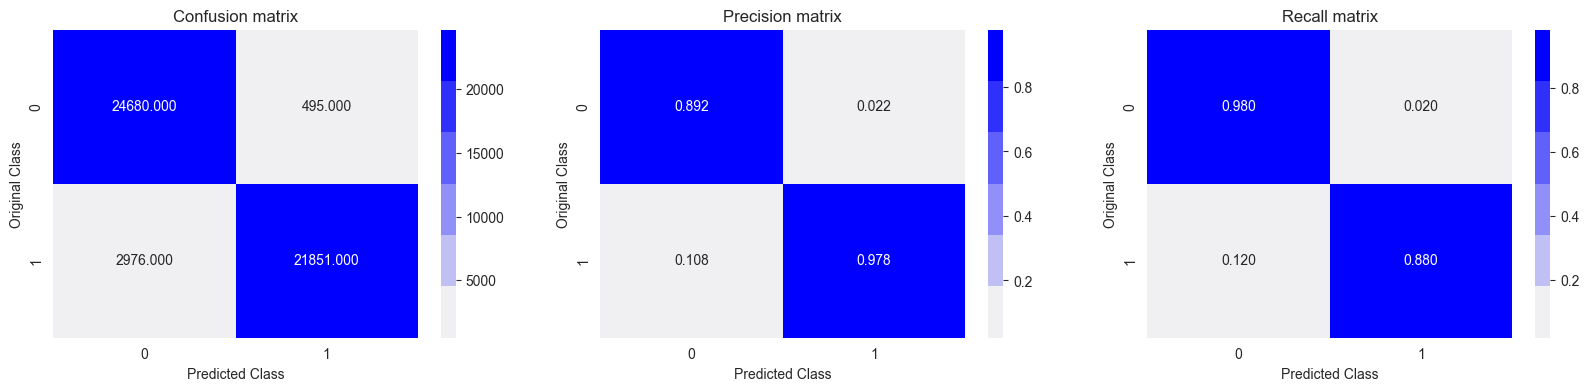

In [107]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

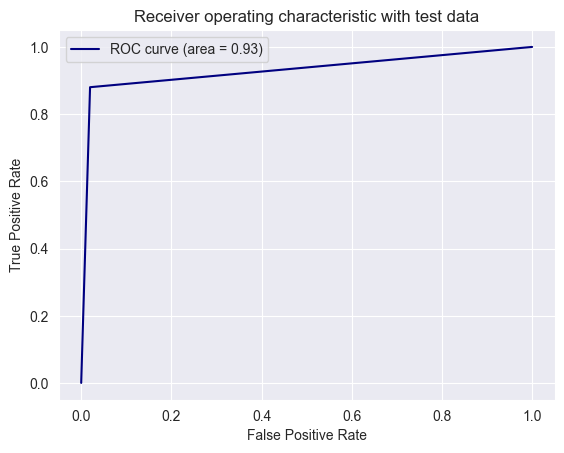

In [108]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

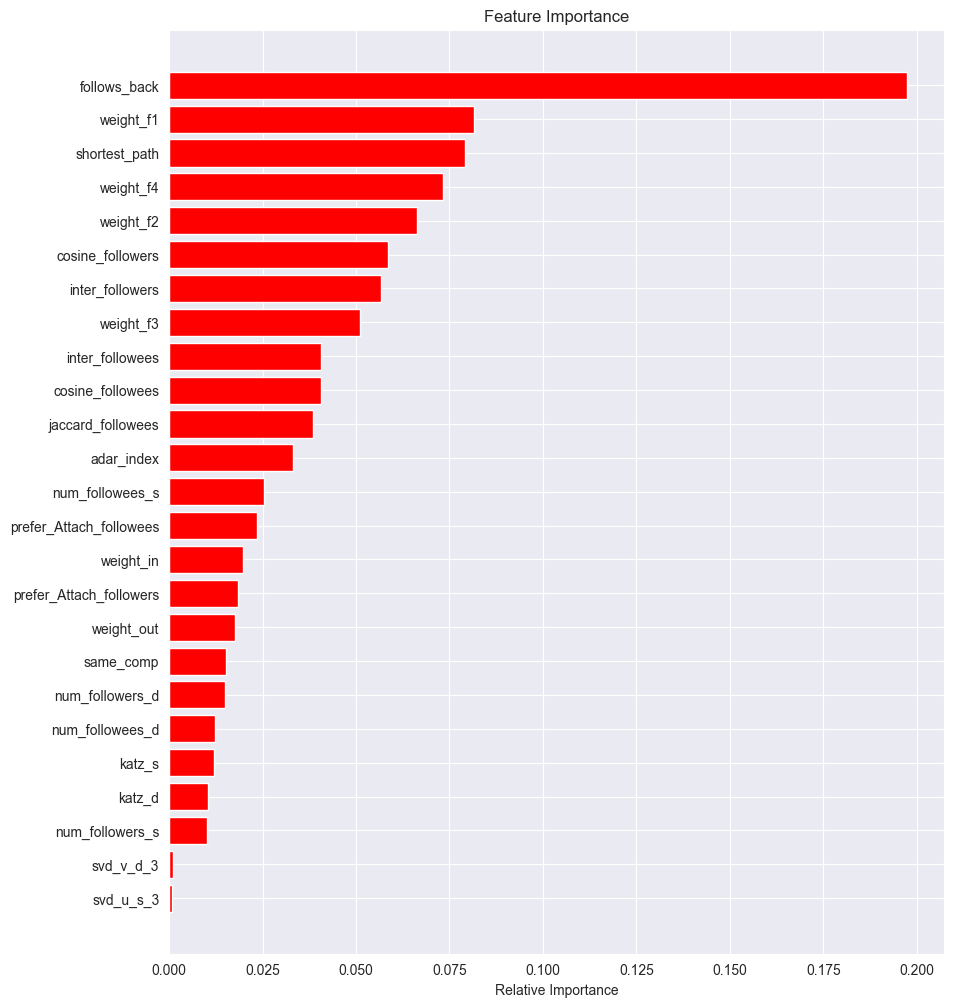

In [109]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBOOST

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25,
                                   return_train_score=True)


model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_train_score'])


In [ ]:
print(model.best_estimator_)

In [ ]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=109,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Procedure and Observation

In [ ]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest','121','14','0.964','0.921'])
x.add_row(['XGBOOST','109','10','0.992','0.926'])
print(x)
